In [157]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Cargar datos (asumiendo que ya habéis unido las features con las labels si venían separadas)
df = pd.read_csv("tanzania_water_pump_org.csv")


In [158]:
df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,14/03/2011,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,06/03/2013,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,25/02/2013,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,28/01/2013,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,13/07/2011,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,03/05/2013,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,07/05/2011,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,11/04/2011,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,08/03/2011,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [159]:
# Separar X (variables) e y (etiqueta/target)
X = df.drop("status_group", axis=1) # Suponiendo que 'status_group' es la clase
y = df["status_group"]

# LA PARTICIÓN CLAVE
# test_size=0.2 deja el 20% para el test final.
# random_state=42 (u otro número) asegura que siempre salga la misma división (reproducibilidad).
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Guardar el Test en un archivo "fuerte" y no tocarlo hasta el final
# Guardar el Train para trabajar con él


In [160]:
# Guardar los conjuntos de entrenamiento
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

# Guardar los conjuntos de prueba (el "cofre" que no se toca)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [161]:
import pandas as pd
import numpy as np
X_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
3607,454,50.0,27/02/2013,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
50870,510,0.0,17/03/2011,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,Lukali,Dodoma,1,6,Bahi,Lamaiti,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
20413,14146,0.0,10/07/2011,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,Chawalikozi,Mbeya,12,6,Mbozi,Ndalambo,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
52806,47410,0.0,12/04/2011,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,Shuleni,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
50091,1288,300.0,05/04/2011,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,Ngholong,Morogoro,5,1,Kilosa,Chakwale,120,True,GeoData Consultants Ltd,VWC,NaN,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [162]:

cols_with_zeros_as_nan = ['construction_year', 'gps_height']

# Reemplazamos 0 por NaN solo en estas columnas
for col in cols_with_zeros_as_nan:
    # Contamos cuántos ceros hay para documentarlo
    n_zeros = (X_train[col] == 0).sum()
    print(f"Variable '{col}': convirtiendo {n_zeros} ceros a NaN.")
    # Transformación
    X_train[col] = X_train[col].replace(0, np.nan)
    X_test[col] = X_test[col].replace(0, np.nan)

# Verificación
print("\nNulos tras corrección de ceros:")
print(X_train[cols_with_zeros_as_nan].isnull().sum())

Variable 'construction_year': convirtiendo 16503 ceros a NaN.
Variable 'gps_height': convirtiendo 16275 ceros a NaN.

Nulos tras corrección de ceros:
construction_year    16503
gps_height           16275
dtype: int64


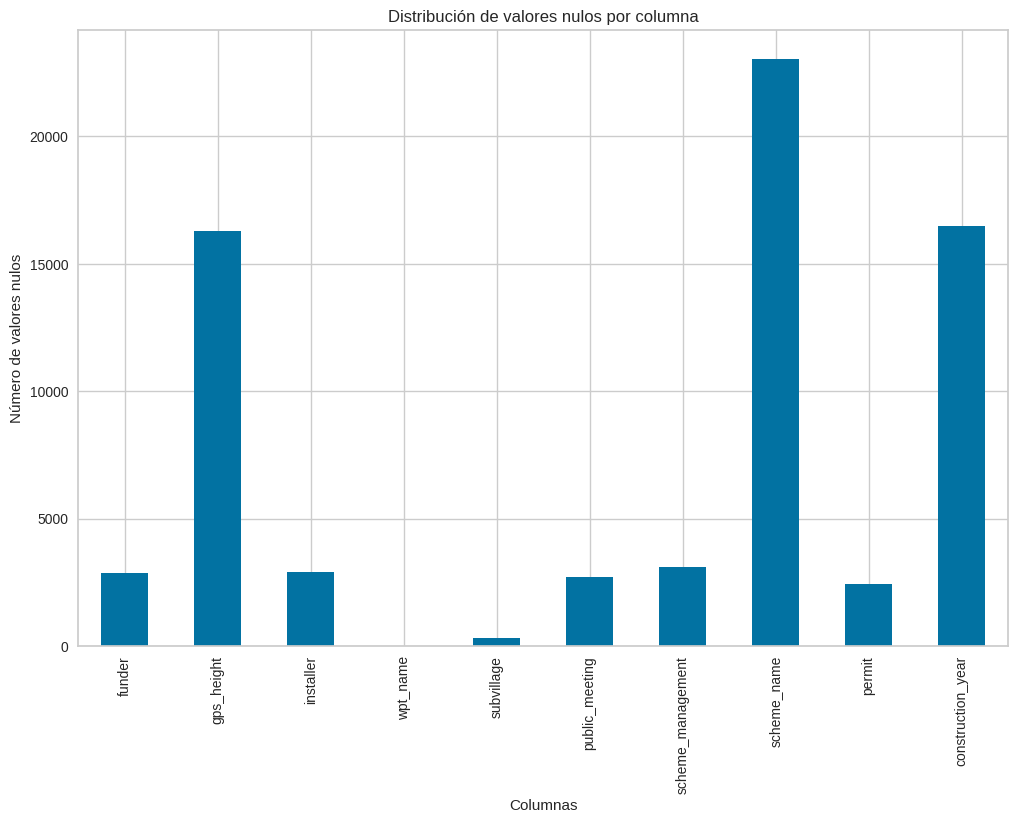

In [163]:
import matplotlib.pyplot as plt
# Contar los valores nulos en cada columna
missing_values = X_train.isnull().sum()

# Filtrar las columnas que tienen valores nulos
missing_values = missing_values[missing_values > 0]

# Crear un gráfico de barras para mostrar la distribución de valores nulos
plt.figure(figsize=(12, 8))
missing_values.plot(kind='bar')
plt.title('Distribución de valores nulos por columna')
plt.xlabel('Columnas')
plt.ylabel('Número de valores nulos')
plt.show()

In [164]:

from sklearn.impute import SimpleImputer
#imputar valores nulos con la media de cada columna y la moda

# Identificar columnas numéricas y categóricas
columnas_numericas = X_train.select_dtypes(include=['number']).columns
columnas_categoricas = X_train.select_dtypes(exclude=['number']).columns

# Imputar columnas numéricas con la mediana
imputador_numerico = SimpleImputer(strategy='median')
X_train_numerico = pd.DataFrame(imputador_numerico.fit_transform(X_train[columnas_numericas]), columns=columnas_numericas)
X_test_numerico = pd.DataFrame(imputador_numerico.transform(X_test[columnas_numericas]), columns=columnas_numericas)

# Imputar columnas categóricas con la moda
imputador_categorico = SimpleImputer(strategy='most_frequent')
X_train_categorico = pd.DataFrame(imputador_categorico.fit_transform(X_train[columnas_categoricas]), columns=columnas_categoricas)
X_test_categorico = pd.DataFrame(imputador_categorico.transform(X_test[columnas_categoricas]), columns=columnas_categoricas)

# Combinar los datos imputados
X_train_imputado = pd.concat([X_train_numerico, X_train_categorico], axis=1)
X_test_imputado = pd.concat([X_test_numerico, X_test_categorico], axis=1)

# Asegurar que las columnas estén en el orden original
X_train_imputado = X_train_imputado[X_train.columns]
X_test_imputado = X_test_imputado[X_test.columns]

# Opcional: Verificar que no queden valores faltantes
print(X_train_imputado.isnull().sum())
print(X_test_imputado.isnull().sum())

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
s

In [166]:
X_train_imputado.to_csv('X_train_prep.csv', index=False)
X_test_imputado.to_csv('X_test_prep.csv', index=False)